In [1]:
# 03_model_baseline_xgboost.ipynb
# Purpose: Train and evaluate a simple XGBoost baseline model.
# Inputs:  processed/training_table.csv
# Outputs: MAE, MAPE metrics; processed/baseline_predictions.csv
# Run 02_feature_engineering.ipynb FIRST.


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

plt.style.use("seaborn-v0_8")

PROJECT_ROOT = Path("..")
PROC_ROOT = PROJECT_ROOT / "Shared project assets" / "data" / "processed"

train_path = PROC_ROOT / "training_table.csv"
print("Training table path:", train_path)
print("Exists:", train_path.exists())


Training table path: ..\Shared project assets\data\processed\training_table.csv
Exists: True


In [3]:
df = pd.read_csv(train_path, parse_dates=["date"])
print("Loaded training_table.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)


Loaded training_table.csv
Shape: (70000, 27)
Columns: ['date', 'sku_id', 'location_id', 'units_sold', 'price', 'promo_flag', 'brand', 'category', 'segment', 'pack_size', 'material', 'base_price', 'cost', 'city', 'region', 'population', 'avg_income_index', 'is_festival', 'month', 'gdp_growth', 'cpi_index', 'consumer_confidence', 'day_of_week', 'week_of_year', 'is_weekend', 'lag_7', 'rolling_14_mean']

Dtypes:
 date                   datetime64[ns]
sku_id                         object
location_id                    object
units_sold                      int64
price                         float64
promo_flag                      int64
brand                          object
category                       object
segment                        object
pack_size                      object
material                       object
base_price                    float64
cost                          float64
city                           object
region                         object
population       

In [4]:
df = pd.read_csv(train_path, parse_dates=["date"])
print("Loaded training_table.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)


Loaded training_table.csv
Shape: (70000, 27)
Columns: ['date', 'sku_id', 'location_id', 'units_sold', 'price', 'promo_flag', 'brand', 'category', 'segment', 'pack_size', 'material', 'base_price', 'cost', 'city', 'region', 'population', 'avg_income_index', 'is_festival', 'month', 'gdp_growth', 'cpi_index', 'consumer_confidence', 'day_of_week', 'week_of_year', 'is_weekend', 'lag_7', 'rolling_14_mean']

Dtypes:
 date                   datetime64[ns]
sku_id                         object
location_id                    object
units_sold                      int64
price                         float64
promo_flag                      int64
brand                          object
category                       object
segment                        object
pack_size                      object
material                       object
base_price                    float64
cost                          float64
city                           object
region                         object
population       

In [5]:
df = df.sort_values("date").reset_index(drop=True)

unique_dates = df["date"].sort_values().unique()
split_idx = int(0.8 * len(unique_dates))
split_date = unique_dates[split_idx]

train_df = df[df["date"] <= split_date].copy()
test_df = df[df["date"] > split_date].copy()

print("Train period:", train_df["date"].min(), "→", train_df["date"].max())
print("Test period :", test_df["date"].min(), "→", test_df["date"].max())
print("Train rows  :", len(train_df))
print("Test rows   :", len(test_df))


Train period: 2024-01-22 00:00:00 → 2024-03-18 00:00:00
Test period : 2024-03-19 00:00:00 → 2024-03-31 00:00:00
Train rows  : 57000
Test rows   : 13000


In [6]:
target = "units_sold"

# Identify numeric columns only (XGBoost requires int, float, or bool)
numeric_cols = df.select_dtypes(include=["int", "float", "bool"]).columns.tolist()

# Remove target from features
feature_cols = [c for c in numeric_cols if c != target]

print("Feature columns:", feature_cols)
print("Number of features:", len(feature_cols))

X_train = train_df[feature_cols]
y_train = train_df[target]
X_test = test_df[feature_cols]
y_test = test_df[target]

print("\nX_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("\nX_train dtypes:\n", X_train.dtypes)


Feature columns: ['price', 'promo_flag', 'base_price', 'cost', 'population', 'avg_income_index', 'is_festival', 'month', 'gdp_growth', 'cpi_index', 'consumer_confidence', 'day_of_week', 'week_of_year', 'is_weekend', 'lag_7', 'rolling_14_mean']
Number of features: 16

X_train shape: (57000, 16)
X_test shape : (13000, 16)

X_train dtypes:
 price                  float64
promo_flag               int64
base_price             float64
cost                   float64
population               int64
avg_income_index       float64
is_festival              int64
month                    int64
gdp_growth             float64
cpi_index              float64
consumer_confidence    float64
day_of_week              int64
week_of_year             int64
is_weekend               int64
lag_7                  float64
rolling_14_mean        float64
dtype: object


In [7]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
)

model.fit(X_train, y_train)
print("Model trained.")


Model trained.


In [8]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

# Safe MAPE calculation (avoid divide by zero)
mask = y_test != 0
mape = np.abs((y_test[mask] - y_pred[mask]) / y_test[mask]).mean() * 100

bias = (y_pred.mean() - y_test.mean()) / y_test.mean()

print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"Bias : {bias:.3f}")


MAE  : 4.17
MAPE : 11.24%
Bias : -0.005


In [9]:
pred_df = test_df[["date", "sku_id", "location_id", target]].copy()
pred_df["predicted_units"] = y_pred
pred_df["abs_error"] = np.abs(pred_df[target] - pred_df["predicted_units"])

# Safe percentage error
pred_df["abs_pct_error"] = np.where(
    pred_df[target] != 0,
    (pred_df["abs_error"] / pred_df[target]) * 100,
    np.nan
)

pred_path = PROC_ROOT / "baseline_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print("Saved predictions to:", pred_path)
pred_df.head()


Saved predictions to: ..\Shared project assets\data\processed\baseline_predictions.csv


,date,sku_id,location_id,units_sold,predicted_units,abs_error,abs_pct_error
57000,2024-03-19,SKU_0041,LOC_020,44,38.237965,5.762035,13.095535
57001,2024-03-19,SKU_0042,LOC_002,71,60.767334,10.232666,14.412206
57002,2024-03-19,SKU_0031,LOC_018,31,37.311161,6.311161,20.358584
57003,2024-03-19,SKU_0047,LOC_020,35,39.905769,4.905769,14.016484
57004,2024-03-19,SKU_0024,LOC_010,58,68.903740,10.903740,18.799552


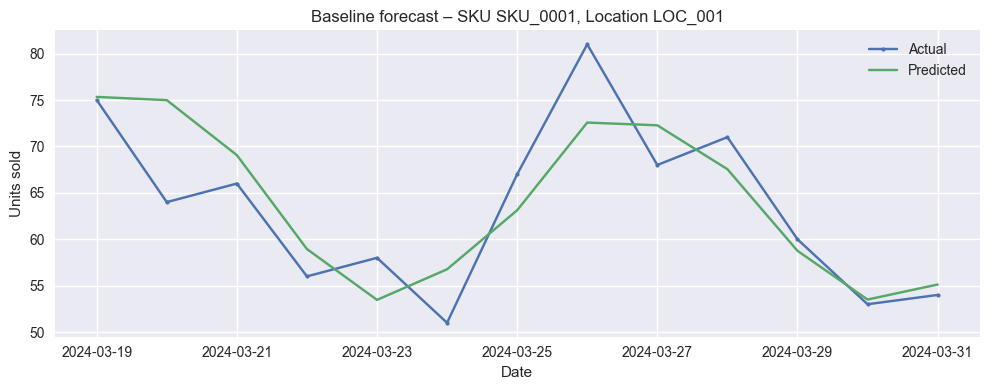

In [10]:
pair_counts = (
    pred_df.groupby(["sku_id", "location_id"])
    .size()
    .sort_values(ascending=False)
)
ex_sku, ex_loc = pair_counts.index[0]

plot_df = (
    pred_df.query("sku_id == @ex_sku and location_id == @ex_loc")
    .sort_values("date")
)

plt.figure(figsize=(10, 4))
plt.plot(plot_df["date"], plot_df[target], label="Actual", marker="o", markersize=3)
plt.plot(plot_df["date"], plot_df["predicted_units"], label="Predicted", marker="x", markersize=3)
plt.title(f"Baseline forecast – SKU {ex_sku}, Location {ex_loc}")
plt.xlabel("Date")
plt.ylabel("Units sold")
plt.legend()
plt.tight_layout()
plt.show()


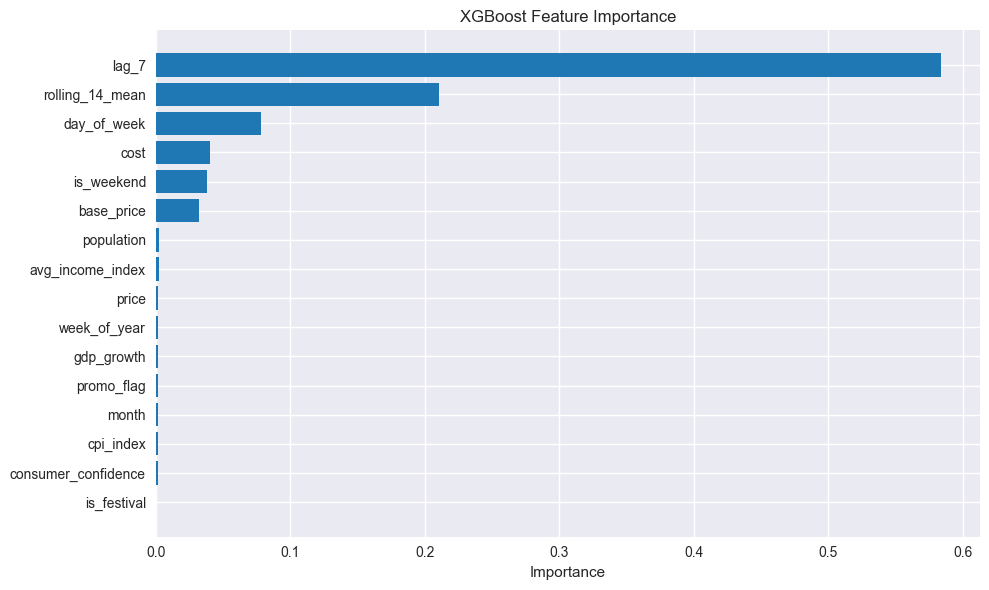

,feature,importance
14,lag_7,0.583625
15,rolling_14_mean,0.210820
11,day_of_week,0.078311
3,cost,0.040075
13,is_weekend,0.038285
2,base_price,0.031892
4,population,0.002380
5,avg_income_index,0.002302
0,price,0.002018
12,week_of_year,0.001875


In [11]:
importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": model.feature_importances_,
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance["feature"], importance["importance"], color="tab:blue")
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

importance


In [ ]:
ML Pipeline Overview
What it predicts

The model forecasts daily units sold for each product (SKU) at each store location, helping the FMCG company optimize inventory and avoid stockouts or overstocking.

​
How it works

01_eda.ipynb – Data Exploration

    Loads and inspects all master tables (SKU, location, festival, macro).

    Checks data quality, missing values, and date ranges.

    Creates a synthetic daily_timeseries.csv (since real data not yet provided).

    ​

02_feature_engineering.ipynb – Feature Building

    Joins daily sales data with all master tables on sku_id, location_id, and date.

    Adds features: SKU attributes (brand, category, price), location demographics (population, income), festival flags, economic indicators, calendar features (day of week, weekend), and lag features (7-day lag, 14-day rolling average).

    Outputs a clean training_table.csv ready for modelling.

    ​

03_model_baseline_xgboost.ipynb – Model Training & Evaluation

    Loads training_table.csv and splits by time (first 80% of dates = training, last 20% = test).

    Trains an XGBoost regressor to predict units_sold using numeric features only.

    Evaluates performance with MAE (absolute error), MAPE (percentage error), and bias metrics.

    Saves predictions to baseline_predictions.csv and plots actual vs predicted demand for sample SKU-location pairs.

    Shows feature importance chart to identify key demand drivers.

Current status

Pipeline runs end-to-end using synthetic data. Once real daily_timeseries.csv is provided, just drop it into raw/datasets/ and re-run 02 → 03 for production forecasts.